In [35]:
import numpy as np
from tqdm import tqdm
import time
from numba import njit, prange, jit
from typing import NamedTuple

In [36]:
# Create a named Tuple class to store the problems
class ProblemInstance(NamedTuple):
    holding_costs: np.ndarray
    setup_costs: np.ndarray
    setup_times: np.ndarray
    demand: np.ndarray
    production_times: np.ndarray
    capacities: np.ndarray
    num_periods: int
    num_products: int

# Create a class to store the population
class Population(NamedTuple):
    population: np.ndarray 
    fitness: np.ndarray 
    

In [37]:
haase = ProblemInstance(
    holding_costs = np.array([1,1,1],np.int32),
    setup_costs = np.array([[0,200,200],[200,0,50],[200,50,0]],np.int32),
    demand = np.array([[0,0,0],[0,0,0],[0,0,0],[6,8,4],[0,0,0],[0,0,0],[0,0,0],[12,14,10]],np.int32),
    production_times = np.array([1,1,1],np.int32),
    setup_times = np.array([[0,0,0],[0,0,0],[0,0,0]],np.int32),
    capacities = np.array([10,10,10,10,10,10,10,10],np.int32),
    num_periods = 8,
    num_products = 3,
)

In [38]:
#==================== POPULATION FUNCTIONS ====================#
@njit
def generate_subpopulation(demand: np.ndarray,
                                 capacities: np.ndarray,
                                 production_times: np.ndarray,
                                 setup_times: np.ndarray,
                                 length: int) -> np.ndarray:
    # Extract sizes once
    periods, products = demand.shape
    
    # Pre-allocate: length individuals × (periods+1 rows) × 3 cols
    population = np.zeros((length, periods + 1, 3), np.int32)

    for ind in range(length):
        # 1) build cumulative backlog matrix
        backlog = np.zeros((periods, products), np.int32)
        cumulative = np.zeros(products, np.int32)
        for p in range(periods):
            src = periods - p - 1
            for prod in range(products):
                cumulative[prod] += demand[src, prod]
                backlog[src, prod] = cumulative[prod]

        # 2) start a fresh solution matrix for this individual
        sol = np.zeros((periods + 1, 3), np.int32)
        last = periods - 1

        # pick a random product with positive backlog in the last period
        cnt = 0
        for prod in range(products):
            if backlog[last, prod] != 0:
                cnt += 1
        valid = np.empty(cnt, np.int32)
        idx = 0
        for prod in range(products):
            if backlog[last, prod] != 0:
                valid[idx] = prod
                idx += 1

        current_prod = valid[np.random.randint(0, cnt)]
        sol[last, 2] = current_prod

        # 3) walk backwards, filling production and setup
        for step in range(periods):
            period = periods - step - 1
            prev_prod = sol[period, 2]

            # produce as much as possible this period
            max_q1 = capacities[period] // production_times[prev_prod]
            q1 = max_q1 if max_q1 <= backlog[period, prev_prod] else backlog[period, prev_prod]
            for future in range(periods):
                backlog[future, prev_prod] -= q1
            sol[period, 0] = q1

            # see if there's spare capacity for a second product
            spare_cap = capacities[period] - production_times[current_prod] * q1
            if spare_cap > 0:
                # find all products still needing backlog this same period
                cnt2 = 0
                for prod in range(products):
                    if backlog[period, prod] != 0:
                        cnt2 += 1

                if cnt2 == 0:
                    # no alternate product → keep the same
                    if period - 1 >= 0:
                        sol[period - 1, 2] = current_prod
                    continue

                valid2 = np.empty(cnt2, np.int32)
                j = 0
                for prod in range(products):
                    if backlog[period, prod] != 0:
                        valid2[j] = prod
                        j += 1

                current_prod = valid2[np.random.randint(0, cnt2)]
                sol[period - 1, 2] = current_prod

                # account for setup time and produce
                max_q2 = (spare_cap - setup_times[current_prod, prev_prod]) // production_times[current_prod]
                q2 = max_q2 if max_q2 <= backlog[period, current_prod] else backlog[period, current_prod]
                for future in range(periods):
                    backlog[future, current_prod] -= q2
                sol[period - 1, 1] = q2

        # store individual solution
        population[ind, :, :] = sol

    return population

@njit
def generate_subpopulation_priority(demand: np.ndarray,
                                    capacities: np.ndarray,
                                    production_times: np.ndarray,
                                    setup_times: np.ndarray,
                                    holding_costs: np.ndarray,
                                    length: int) -> np.ndarray:
    periods, products = demand.shape
    population = np.zeros((length, periods + 1, 3), np.int32)

    for ind in range(length):
        backlog = np.zeros((periods, products), np.int32)
        cumulative = np.zeros(products, np.int32)
        for p in range(periods):
            src = periods - p - 1
            for prod in range(products):
                cumulative[prod] += demand[src, prod]
                backlog[src, prod] = cumulative[prod]

        sol = np.zeros((periods + 1, 3), np.int32)
        last = periods - 1

        # Select product with highest holding cost among those with backlog
        best_prod = -1
        best_cost = -1
        for prod in range(products):
            if backlog[last, prod] > 0 and holding_costs[prod] > best_cost:
                best_cost = holding_costs[prod]
                best_prod = prod
        current_prod = best_prod
        sol[last, 2] = current_prod

        for step in range(periods):
            period = periods - step - 1
            prev_prod = sol[period, 2]

            max_q1 = capacities[period] // production_times[prev_prod]
            q1 = max_q1 if max_q1 <= backlog[period, prev_prod] else backlog[period, prev_prod]
            for future in range(periods):
                backlog[future, prev_prod] -= q1
            sol[period, 0] = q1

            spare_cap = capacities[period] - production_times[current_prod] * q1
            if spare_cap > 0:
                # pick highest holding cost product still needing backlog this period
                best_alt_prod = -1
                best_alt_cost = -1
                for prod in range(products):
                    if backlog[period, prod] > 0 and holding_costs[prod] > best_alt_cost:
                        best_alt_cost = holding_costs[prod]
                        best_alt_prod = prod

                if best_alt_prod == -1:
                    if period - 1 >= 0:
                        sol[period - 1, 2] = current_prod
                    continue

                current_prod = best_alt_prod
                sol[period - 1, 2] = current_prod

                max_q2 = (spare_cap - setup_times[current_prod, prev_prod]) // production_times[current_prod]
                q2 = max_q2 if max_q2 <= backlog[period, current_prod] else backlog[period, current_prod]
                for future in range(periods):
                    backlog[future, current_prod] -= q2
                sol[period - 1, 1] = q2

        population[ind, :, :] = sol

    return population

@njit
def create_starting_population(demand: np.ndarray,
                                capacities: np.ndarray,
                                production_times: np.ndarray,
                                setup_times: np.ndarray,
                                individuals_per_population: int,
                                num_subpopulations: int,
                                num_children) -> np.ndarray:
    
    num_periods, _ = demand.shape
    periods_plus1 = num_periods + 1

    # Allocate full space: 2 * individuals to leave room for children
    population = np.zeros((num_subpopulations, num_children + individuals_per_population, periods_plus1, 3), dtype=np.int32)

    for i in range(num_subpopulations):
        subpop = generate_subpopulation(
            demand, capacities, production_times, setup_times, individuals_per_population
        )
        # Insert only in the first half
        for j in range(individuals_per_population):
            for t in range(periods_plus1):
                for k in range(3):
                    population[i, j, t, k] = subpop[j, t, k]

    return population

#==================== EVALUATION FUNCTIONS ====================#

def evaluate_individual_new(
    solution,  # shape: (periods+1, 3)
    demand,
    holding_costs,
    setup_costs,
    setup_times,
    production_times,
    capacity_per_period,
    penalty_shortage,
    penalty_overtime
):
    periods, products = demand.shape
    periods_plus1 = periods + 1

    lots1 = solution[1:, 0].astype(np.int32)
    lots2 = solution[:-1, 1].astype(np.int32)
    seq = solution[:, 2].astype(np.int32)

    # --- Production matrix ---
    production = np.zeros((periods, products), dtype=np.int32)
    for t in range(periods):
        production[t, seq[t + 1]] += lots1[t]
        production[t, seq[t]] += lots2[t]

    print("\n=== Production Matrix ===")
    print(production)

    # --- Inventory matrix ---
    inventory = np.zeros((periods, products), dtype=np.float64)
    for m in range(products):
        cum = 0.0
        for t in range(periods):
            cum += production[t, m] - demand[t, m]
            inventory[t, m] = cum

    print("\n=== Inventory Matrix ===")
    print(inventory)

    # --- Holding and shortage costs ---
    hold_costs_per_product = np.sum(inventory * holding_costs, axis=0)
    hold_cost_total = np.sum(hold_costs_per_product)

    shortage_violations = inventory < 0
    shortage_units = -np.sum(inventory[shortage_violations])
    shortage_penalty = shortage_units * penalty_shortage

    print("\n--- Holding Costs per Product ---")
    for i in range(products):
        print(f"Product {i}: {hold_costs_per_product[i]:.2f}")

    print("\nTotal Holding Cost:", hold_cost_total)
    print("Total Shortage Penalty:", shortage_penalty)
    print("Total Shortage Violations (units):", shortage_units)

    # --- Setup and production time ---
    setup_time = np.zeros(periods, dtype=np.int32)
    for t in range(periods):
        setup_time[t] = setup_times[seq[t], seq[t + 1]]

    prod_time = np.sum(production * production_times, axis=1)
    total_time = prod_time + setup_time
    overtime_violations = np.maximum(total_time - capacity_per_period, 0)
    overtime_penalty = np.sum(overtime_violations) * penalty_overtime

    print("\nSetup Times per Period:", setup_time)
    print("Production Times per Period:", prod_time)
    print("Total Time per Period:", total_time)
    print("Overtime Violations (units):", np.sum(overtime_violations))
    print("Overtime Penalty:", overtime_penalty)

    # --- Setup cost ---
    setup_c = 0.0
    for t in range(periods):
        setup_c += setup_costs[seq[t], seq[t + 1]]

    print("\nTotal Setup Cost:", setup_c)

    total_cost = hold_cost_total + shortage_penalty + overtime_penalty + setup_c
    print("\n=== Final Total Cost ===")
    print(total_cost)

@njit
def evaluate_subpopulation_pen(solutions, demand, holding_costs, setup_costs, setup_times,
                           production_times, capacity_per_period, penalty_shortage, penalty_overtime) -> np.ndarray:
    N, periods_plus1, _ = solutions.shape
    periods = periods_plus1 - 1
    products = demand.shape[1]

    # Safely promote to int32
    lots1 = solutions[:, 1:, 0].astype(np.int32)
    lots2 = solutions[:, :-1, 1].astype(np.int32)
    seq = solutions[:, :, 2].astype(np.int32)

    production = np.zeros((N, periods, products), dtype=np.int32)
    for i in range(N):
        for t in range(periods):
            production[i, t, seq[i, t + 1]] += lots1[i, t]
            production[i, t, seq[i, t]] += lots2[i, t]

    # Compute inventory
    inventory = np.zeros((N, periods, products), dtype=np.float64)
    for i in range(N):
        for m in range(products):
            cum = 0.0
            for t in range(periods):
                cum += production[i, t, m] - demand[t, m]
                inventory[i, t, m] = cum

    # Holding cost and shortage penalty (scaled by holding cost)
    hold_cost = np.zeros(N, dtype=np.float64)
    shortage = np.zeros(N, dtype=np.float64)
    for i in range(N):
        for t in range(periods):
            for m in range(products):
                inv = inventory[i, t, m]
                hold_cost[i] += inv * holding_costs[m]
                if inv < 0:
                    shortage[i] += -inv * (penalty_shortage * holding_costs[m])

    # Production time and setup time
    prod_time = np.sum(production * production_times, axis=2)
    setup_time = np.zeros((N, periods), dtype=np.int32)
    for i in range(N):
        for t in range(periods):
            setup_time[i, t] = setup_times[seq[i, t], seq[i, t + 1]]

    total_time = prod_time + setup_time
    overtime = np.sum(np.maximum(total_time - capacity_per_period, 0), axis=1) * penalty_overtime

    # Setup costs
    setup_cost = np.zeros(N, dtype=np.float64)
    for i in range(N):
        for t in range(periods):
            setup_cost[i] += setup_costs[seq[i, t], seq[i, t + 1]]

    return hold_cost + shortage + overtime + setup_cost

#==================== CROSSOVER FUNCTIONS ====================#
@njit
def select_parents_subpop(fitness: np.ndarray, num_children: int, valid_size: int) -> tuple:
    inverse_fitness = 1.0 / fitness[:valid_size]
    probabilities = inverse_fitness / np.sum(inverse_fitness)

    # Cumulative probabilities
    cumulative = np.empty(valid_size, dtype=np.float64)
    cumulative[0] = probabilities[0]
    for i in range(1, valid_size):
        cumulative[i] = cumulative[i - 1] + probabilities[i]

    # Draw random numbers
    rand_vals = np.random.rand(num_children * 2)
    indices = np.empty(num_children * 2, dtype=np.int32)

    for i in range(num_children * 2):
        r = rand_vals[i]
        for j in range(valid_size):
            if r <= cumulative[j]:
                indices[i] = j
                break

    return indices[:num_children], indices[num_children:]

def two_point_crossover_numpy(solutions: np.ndarray, parent_1_idx: np.ndarray, parent_2_idx: np.ndarray) -> np.ndarray:
    """
    Performs two-point crossover using NumPy operations.
    :param solutions: Full population array (N, periods + 1, 3)
    :param parent_1_idx: Indices of first parents
    :param parent_2_idx: Indices of second parents
    :return: Children array (2 * N, periods + 1, 3)
    """
    parent_1 = solutions[parent_1_idx]  # (num_children, P+1, 3)
    parent_2 = solutions[parent_2_idx]
    N, periods_plus1, _ = parent_1.shape

    # Generate crossover points
    point1 = np.random.randint(0, periods_plus1 - 1, size=N)
    point2 = np.random.randint(0, periods_plus1, size=N)
    start = np.minimum(point1, point2)
    end = np.maximum(point1, point2)

    # Generate mask for crossover region
    period_indices = np.arange(periods_plus1)
    mask = (period_indices[None, :] >= start[:, None]) & (period_indices[None, :] <= end[:, None])
    mask = mask[:, :, None]  # Expand to 3rd dim

    # Apply crossover
    children = np.empty((2 * N, periods_plus1, 3), dtype=solutions.dtype)
    children[:N] = np.where(mask, parent_2, parent_1)
    children[N:] = np.where(mask, parent_1, parent_2)

    return children

@njit
def two_point_crossover_numba(solutions: np.ndarray, parent_1_idx: np.ndarray, parent_2_idx: np.ndarray) -> np.ndarray:
    parent_1 = solutions[parent_1_idx]  # (num_children, P+1, 3)
    parent_2 = solutions[parent_2_idx]
    N, periods_plus1, _ = parent_1.shape

    children = np.empty((2 * N, periods_plus1, 3), dtype=solutions.dtype)

    for n in range(N):
        p1 = np.random.randint(0, periods_plus1 - 1)
        p2 = np.random.randint(0, periods_plus1)
        start = min(p1, p2)
        end = max(p1, p2)

        for t in range(periods_plus1):
            for c in range(3):
                # First child
                if start <= t <= end:
                    children[n, t, c] = parent_2[n, t, c]
                else:
                    children[n, t, c] = parent_1[n, t, c]
                # Second child
                if start <= t <= end:
                    children[N + n, t, c] = parent_1[n, t, c]
                else:
                    children[N + n, t, c] = parent_2[n, t, c]

    return children

#==================== MUTATION FUNCTIONS ====================#
@njit
def mutate_lotsizes(solutions: np.ndarray, mutation_rate: float, step: int, max_lotsize: int) -> np.ndarray:

    N, P1, _ = solutions.shape
    for i in range(N):
        for t in range(P1):
            for l in range(2):  # only mutate lotsize columns [0, 1]
                if np.random.rand() < mutation_rate:
                    delta = np.random.randint(-step, step + 1)
                    new_val = solutions[i, t, l] + delta
                    # Clamp between 0 and max_lotsize
                    if new_val < 0:
                        new_val = 0
                    elif new_val > max_lotsize:
                        new_val = max_lotsize
                    solutions[i, t, l] = new_val

    return solutions

@njit
def mutate_lotsizes_diff(solutions: np.ndarray, mutation_rate: float, step: int = 1) -> np.ndarray:
    N, T, _ = solutions.shape

    for i in range(N):
        for t in range(T):
            if np.random.rand() < mutation_rate:
                direction = np.random.randint(0, 2)
                from_idx = 1 - direction
                to_idx = direction

                available = solutions[i, t, from_idx]
                if available > 0:
                    max_delta = min(step, available)
                    delta = np.random.randint(1, max_delta + 1)
                    solutions[i, t, from_idx] -= delta
                    solutions[i, t, to_idx] += delta

    return solutions

@njit
def clamp_lotsizes(solutions: np.ndarray, max_lotsize: int) -> None:
    N, T, _ = solutions.shape
    for i in range(N):
        for t in range(T):
            for l in range(2):
                if solutions[i, t, l] < 0:
                    solutions[i, t, l] = 0
                elif solutions[i, t, l] > max_lotsize:
                    solutions[i, t, l] = max_lotsize

@njit
def mutate_period_swaps(solutions: np.ndarray, mutation_rate: float, max_swap_distance:int) -> np.ndarray:

    N, P1, _ = solutions.shape
    for i in range(N):
        if np.random.rand() < mutation_rate:
            # Pick a swap source position, ignoring ghost period at 0
            src = np.random.randint(1, P1)

            # Pick a direction and swap distance
            direction = 1 if np.random.rand() < 0.5 else -1
            offset = np.random.randint(1, max_swap_distance + 1)
            tgt = src + direction * offset

            # Clamp to valid range [1, P1-1]
            if tgt < 1:
                tgt = 1
            elif tgt >= P1:
                tgt = P1 - 1

            # Swap rows src <-> tgt
            for j in range(3):  # manually unroll to avoid slicing
                tmp = solutions[i, src, j]
                solutions[i, src, j] = solutions[i, tgt, j]
                solutions[i, tgt, j] = tmp
    
    return solutions

@njit
def mutate_shift_periods_old(solutions: np.ndarray, mutation_rate: float) -> np.ndarray:

    N, P1, _ = solutions.shape  # P1 = periods + 1
    for i in range(N):
        if np.random.rand() < mutation_rate:
            src = np.random.randint(1, P1)
            tgt = np.random.randint(1, P1)

            if src == tgt:
                continue

            # Extract row
            row0, row1, row2 = solutions[i, src, 0], solutions[i, src, 1], solutions[i, src, 2]

            if src < tgt:
                for j in range(src, tgt):
                    solutions[i, j, 0] = solutions[i, j + 1, 0]
                    solutions[i, j, 1] = solutions[i, j + 1, 1]
                    solutions[i, j, 2] = solutions[i, j + 1, 2]
            else:
                for j in range(src, tgt, -1):
                    solutions[i, j, 0] = solutions[i, j - 1, 0]
                    solutions[i, j, 1] = solutions[i, j - 1, 1]
                    solutions[i, j, 2] = solutions[i, j - 1, 2]

            solutions[i, tgt, 0] = row0
            solutions[i, tgt, 1] = row1
            solutions[i, tgt, 2] = row2

    return solutions

@njit
def mutate_products(solutions: np.ndarray, mutation_rate: float, num_products: int) -> np.ndarray:
   
    N, P1, _ = solutions.shape
    for i in range(N):
        for j in range(P1):
            if np.random.rand() < mutation_rate:
                solutions[i, j, 2] = np.random.randint(0, num_products)

    return solutions

@njit
def mutate_neighbour_products(solutions: np.ndarray, mutation_rate: float, num_products: int) -> np.ndarray:
   
    N, P1, _ = solutions.shape
    for i in range(N):
        for j in range(P1):
            if np.random.rand() < mutation_rate:
                direction = 1 if np.random.rand() < 0.5 else -1
                new_val = solutions[i, j, 2] + direction

                # Clamp to valid product range
                if new_val < 0:
                    new_val = 0
                elif new_val >= num_products:
                    new_val = num_products - 1

                solutions[i, j, 2] = new_val

    return solutions

@njit
def mutate_shift_periods(solutions: np.ndarray, mutation_rate: float, shift_range: int) -> np.ndarray:
    N, P1, _ = solutions.shape

    for i in range(N):
        if np.random.rand() < mutation_rate:
            src = np.random.randint(1, P1)

            # Determine allowed target range
            lower = max(1, src - shift_range)
            upper = min(P1, src + shift_range + 1)

            tgt = np.random.randint(lower, upper)

            if src == tgt:
                continue

            row0, row1, row2 = solutions[i, src, 0], solutions[i, src, 1], solutions[i, src, 2]

            if src < tgt:
                for j in range(src, tgt):
                    solutions[i, j, 0] = solutions[i, j + 1, 0]
                    solutions[i, j, 1] = solutions[i, j + 1, 1]
                    solutions[i, j, 2] = solutions[i, j + 1, 2]
            else:
                for j in range(src, tgt, -1):
                    solutions[i, j, 0] = solutions[i, j - 1, 0]
                    solutions[i, j, 1] = solutions[i, j - 1, 1]
                    solutions[i, j, 2] = solutions[i, j - 1, 2]

            solutions[i, tgt, 0] = row0
            solutions[i, tgt, 1] = row1
            solutions[i, tgt, 2] = row2

    return solutions

#==================== SELECTION FUNCTIONS ====================#

@njit
def boltzmann_temperature(progress: float, T_max: float = 5.0, T_min: float = 0.1, steepness: float = 8.0) -> float:
    sigmoid = 1.0 / (1.0 + np.exp(-steepness * (progress - 0.5)))
    return T_max - (T_max - T_min) * sigmoid

@njit
def natural_selection_boltzmann_inplace(
    solutions: np.ndarray,
    fitness: np.ndarray,
    end_size: int,
    elite_ratio: float,
    temperature: float
):
    N = fitness.shape[0]  # total solutions (should be 2 * end_size)
    P1 = solutions.shape[1]
    num_elite = int(end_size * elite_ratio)

    # --- Step 1: Elitism ---
    sorted_indices = np.argsort(fitness)  # ascending fitness (lower is better)
    for i in range(num_elite):
        idx = sorted_indices[i]
        solutions[i] = solutions[idx]
        fitness[i] = fitness[idx]

    # Step 2: Boltzmann Selection for rest
    min_fit = np.min(fitness[:N])
    max_fit = np.max(fitness[:N])
    normalized = np.empty(N, dtype=np.float64)

    if max_fit - min_fit == 0:
        for i in range(N):
            normalized[i] = 1.0
    else:
        for i in range(N):
            normalized[i] = 1.0 - (fitness[i] - min_fit) / (max_fit - min_fit)

    scores = np.exp(normalized / temperature)
    total_score = np.sum(scores)
    probabilities = scores / total_score

    # Sample rest and write into front portion
    for i in range(num_elite, end_size):
        r = np.random.rand()
        cumulative = 0.0
        for j in range(N):
            cumulative += probabilities[j]
            if r < cumulative:
                solutions[i] = solutions[j]
                fitness[i] = fitness[j]
                break

@njit
def natural_selection_boltzmann(
    solutions: np.ndarray,
    fitness: np.ndarray,
    end_size: int,
    elite_ratio: float,
    temperature: float
):
    N = fitness.shape[0]
    P1 = solutions.shape[1]
    num_elite = int(end_size * elite_ratio)

    # --- Step 1: Elitism ---
    sorted_indices = np.argsort(fitness)
    for i in range(num_elite):
        idx = sorted_indices[i]
        solutions[i] = solutions[idx]
        fitness[i] = fitness[idx]

    # --- Step 2: Boltzmann Selection for rest ---
    min_fit = np.min(fitness)
    max_fit = np.max(fitness)
    normalized = np.empty(N, dtype=np.float64)

    if max_fit - min_fit == 0:
        for i in range(N):
            normalized[i] = 1.0
    else:
        for i in range(N):
            normalized[i] = 1.0 - (fitness[i] - min_fit) / (max_fit - min_fit)

    scores = np.exp(normalized / temperature)
    total_score = np.sum(scores)
    probabilities = scores / total_score

    # --- Random weighted sampling ---
    for i in range(num_elite, end_size):
        r = np.random.rand()
        cumulative = 0.0
        for j in range(N):
            cumulative += probabilities[j]
            if r < cumulative:
                solutions[i] = solutions[j]
                fitness[i] = fitness[j]
                break

#==================== SELECTION FUNCTIONS ====================#

@njit
def reset_population_perc_inplace(
    demand: np.ndarray,
    capacities: np.ndarray,
    production_times: np.ndarray,
    setup_times: np.ndarray,
    solutions: np.ndarray,
    fitness: np.ndarray,
    new_size: int,
    preserve_ratio: float,
    penalty_shortage: int,
    penalty_overtime: int,
    holding_costs: np.ndarray,
    setup_costs: np.ndarray,
    prog:float
):
    num_preserve = max(1, int(new_size * preserve_ratio))
    periods_plus1 = solutions.shape[1]

    # Step 1: Get indices of elites from the first `new_size` individuals
    elite_indices = np.argsort(fitness[:new_size])[:num_preserve]

    # Step 2: Copy elites into beginning of the array
    for i in range(num_preserve):
        solutions[i] = solutions[elite_indices[i]]
        fitness[i] = fitness[elite_indices[i]]

    generated = generate_subpopulation(demand, capacities, production_times, setup_times, new_size)

    for i in range(new_size):
        solutions[num_preserve + i] = generated[i]


    # Step 4: Re-evaluate full new population (first `new_size`)
    fitness[:new_size] = evaluate_subpopulation_pen(
        solutions[:new_size],
        demand,
        holding_costs,
        setup_costs,
        setup_times,
        production_times,
        capacities,
        penalty_shortage,
        penalty_overtime
    )
 

#==================== NETWORK FUNCTIONS ====================#

def create_er_network(solutions: np.ndarray, chance=0.2):
    subpops = solutions.shape[0]
    network = np.zeros((subpops, subpops), dtype=np.int32)

    for i in range(subpops):
        for j in range(i + 1, subpops):  
            if np.random.rand() < chance:
                network[i, j] = 1
                network[j, i] = 1  

    for i in range(subpops):
        if not np.any(network[i]):  # no neighbors
            j = np.random.choice([x for x in range(subpops) if x != i])
            network[i, j] = 1
            network[j, i] = 1

    return network

@njit
def update_network(solutions, fitness, network) -> np.ndarray:
    subpops, inds, periods, products = solutions.shape

    elite_ind = np.zeros((subpops, periods, products), dtype=np.int32)
    elite_fit = np.zeros(subpops, dtype=np.int32)

    # Step 1: Identify elite individuals in each subpopulation
    for i in range(subpops):
        best_idx = 0
        best_fit = fitness[i, 0]
        for j in range(1, inds):
            if fitness[i, j] < best_fit:
                best_fit = fitness[i, j]
                best_idx = j
        elite_ind[i] = solutions[i, best_idx]
        elite_fit[i] = best_fit

    # Step 2: Select a random subpopulation
    selected_subpop = np.random.randint(subpops)

    # Step 3: Find best neighbor
    best_neighbor_fit = 32767  # Max value for int16
    best_neighbor_idx = -1
    for i in range(subpops):
        if i == selected_subpop or network[selected_subpop, i] == 1:
            if elite_fit[i] < best_neighbor_fit:
                best_neighbor_fit = elite_fit[i]
                best_neighbor_idx = i

    # Step 4: Migrate best elite to neighbors
    for i in range(subpops):
        if i == selected_subpop or network[selected_subpop, i] == 1:
            solutions[i, 0] = elite_ind[best_neighbor_idx]
            fitness[i, 0] = elite_fit[best_neighbor_idx]

    for i in range(subpops):
        best_idx = 0
        best_fit = fitness[i, 0]
        for j in range(1, inds):
            if fitness[i, j] < best_fit:
                best_fit = fitness[i, j]
                best_idx = j
        elite_ind[i] = solutions[i, best_idx]
        elite_fit[i] = best_fit

    return solutions, fitness, elite_fit


In [39]:
@njit
def run_algorithm(problem: ProblemInstance,
              algorithm: Population,
              network: np.ndarray,
              num_subpopulations: int,
              num_indiv: int,
              penalty_shortage: int,
              penalty_overtime: int,
              num_children: int,
              elite_ratio: float,
              temp_max: float,
              temp_min: float,
              max_lotsize: int,
              best_values:np.ndarray,
              stagnation_count:np.ndarray,
              progress:float,
              swap_dist: int,
              mutation_perc:float):
    

    for i in range(num_subpopulations):

        # Perform the crossovers
        idx1, idx2 = select_parents_subpop(algorithm.fitness[i], num_children//2, num_indiv)

        # Call numpy crossover
        children = two_point_crossover_numba(algorithm.population[i], idx1, idx2)

        # Replace children into second half of array
        algorithm.population[i, -num_children:] = children

        # Mutate only the children
        algorithm.population[i, -num_children:] = mutate_lotsizes(algorithm.population[i, -num_children:],0.01*mutation_perc,1,max_lotsize)
        algorithm.population[i, -num_children:] = mutate_lotsizes_diff(algorithm.population[i, -num_children:],0.01*mutation_perc,1)
        algorithm.population[i, -num_children:] = mutate_period_swaps(algorithm.population[i, -num_children:],0.02*mutation_perc,swap_dist)
        algorithm.population[i, -num_children:] = mutate_shift_periods(algorithm.population[i, -num_children:],0.02*mutation_perc,swap_dist)
        #algorithm.population[i, -num_children:] = mutate_neighbour_products(algorithm.population[i, -num_children:],0.01,problem.num_products)

        # Evaluate the newly generated children
        algorithm.fitness[i, -num_children:] = evaluate_subpopulation_pen(
            algorithm.population[i, -num_children:],
            problem.demand, problem.holding_costs, problem.setup_costs, problem.setup_times,
            problem.production_times, problem.capacities,
            penalty_shortage, penalty_overtime
        )
    
        T = boltzmann_temperature(progress, temp_max, temp_min)
        natural_selection_boltzmann(algorithm.population[i], algorithm.fitness[i], num_indiv, elite_ratio, T)


    # Network migration step
    algorithm.population[:, :num_indiv], algorithm.fitness[:, :num_indiv],elite_fit = update_network(
        algorithm.population[:, :num_indiv],
        algorithm.fitness[:, :num_indiv],
        network
        )



    # Check for stagnation
    for i in range(num_subpopulations):
        if elite_fit[i] >= best_values[i]:
            stagnation_count[i] += 1
        else:
            stagnation_count[i] = 0
            best_values[i] = elite_fit[i]

        # Reset if stagnation exceeded threshold (e.g. 30 generations)
        if stagnation_count[i] >= 200:
            reset_population_perc_inplace(
                demand=problem.demand,
                capacities=problem.capacities,
                production_times=problem.production_times,
                setup_times=problem.setup_times,
                solutions=algorithm.population[i, :num_indiv],
                fitness=algorithm.fitness[i, :num_indiv],
                new_size=num_indiv,
                preserve_ratio=0.1,
                penalty_shortage=penalty_shortage,
                penalty_overtime=penalty_overtime,
                setup_costs=problem.setup_costs,
                holding_costs=problem.holding_costs,
                prog=progress
            )
            stagnation_count[i] = 0
            best_values[i] = np.min(algorithm.fitness[i, :num_indiv])  # update to new elite value



In [40]:
dem = np.array([[45, 0, 23, 39, 26, 0],
[42, 35, 0, 26, 45, 42],
[0, 44, 43, 25, 23, 0],
[41, 0, 29, 45, 38, 36],
[0, 39, 39, 35, 0, 43],
[22, 14, 13, 17, 30, 16]],dtype=np.int32)
demand = []

for i in range(6):

    for x in range(4):
        demand.append([0 for i in range(6)])
    demand.append(dem[i])

demand = np.array(demand,dtype=np.int32)
problem_excel = ProblemInstance(
    holding_costs = np.array([2, 2, 2, 2, 2, 2],dtype=np.int32),
    setup_costs = np.array([[0, 250, 200, 200, 300, 210],
                            [250, 0, 200, 280, 310, 230],
                            [250, 200, 0, 200, 270, 250],
                            [200, 280, 200, 0, 220, 240],
                            [300, 310, 270, 220, 0, 280],
                            [210, 230, 250, 240, 280, 0]],dtype=np.int32),
setup_times = np.array([[0, 11, 18, 18, 11, 13],
                [11, 0, 15, 13, 17, 14],
                [18, 15, 0, 16, 12, 12],
                [18, 13, 16, 0, 18, 16],
                [11, 17, 12, 18, 0, 20],
                [13, 14, 12, 16, 20, 0]],dtype=np.int32),
 demand = demand,
 production_times = np.array([1,1,1,1,1,1]),
 capacities = np.array([47 for i in range(30)],dtype=np.int32),
        num_periods = 30,
        num_products = 6)

In [41]:
def main(problem:ProblemInstance,num_subpopulations:int,individuals_per_propulation:int,
         penalty_shortage:int,penalty_overtime:int,poisson_prob_network:float,num_children:int,
         elite_ratio:float,max_temp:float,min_temp:float,max_lotsize:int):
    
    # Create the starting population and evaluate it
    solutions = create_starting_population(problem.demand,problem.capacities,problem.production_times,problem.setup_times,individuals_per_propulation,num_subpopulations,num_children)

    for i in range(num_subpopulations):

        clamp_lotsizes(solutions[i], max_lotsize)

    fitness = np.zeros((num_subpopulations,individuals_per_propulation+num_children),dtype=np.int32)
    for pop in range(num_subpopulations):

        fitness[pop] = evaluate_subpopulation_pen(solutions[pop],problem.demand,problem.holding_costs,problem.setup_costs,
                                     problem.setup_times,problem.production_times,problem.capacities,penalty_shortage,penalty_overtime)

    # Store the Population
    algorithm = Population(
        population = solutions,
        fitness = fitness
    )

    # Create the Network
    network = create_er_network(algorithm.population,poisson_prob_network)

    # Initialize metrics
    iteration = 0
    best_values = np.array([100000 for i in range(num_subpopulations)],dtype=np.int32)
    stagnation_count = np.zeros((num_subpopulations), dtype=np.int32)
    time_limit = 120
    elapsed_time = 0
    start_time = time.time()
    swap_positions_initialize = problem.num_periods

    #print(algorithm.population[1,1],algorithm.fitness[1,1])
    # Create a progress bar
    progress = tqdm(total=time_limit, desc="Optimizing", dynamic_ncols=True)


    while elapsed_time <= time_limit:

        # Update the progess
        prog = elapsed_time/time_limit

        # Calculate a factor for the mutations
        sigmoid = 1.0 / (1.0 + np.exp(-12 * (prog - 0.4)))
        mutation_perc = 40 - (40 - 1) * sigmoid
        factor = 1 - (1 - 0.1) * sigmoid

        swap_dist = max(5,int(factor * swap_positions_initialize))


        # Run the main algorithm
        run_algorithm(
        problem,algorithm,network,num_subpopulations,individuals_per_propulation,
        penalty_shortage,penalty_overtime,num_children,elite_ratio,max_temp,min_temp,max_lotsize,
        best_values,stagnation_count,prog,swap_dist,mutation_perc)

        #print('AFTER:')
        #print(algorithm.population[1])
        #break

        # Update Iterations and Time
        elapsed_time = round(time.time() - start_time,0)
        progress.update(elapsed_time - progress.n)
        iteration += 1

        current_best = best_values.min()
        if current_best == 396:
            break

        # Update the Progress bar
        progress.set_description(f"Iter {iteration+1}, Best: {current_best:.0f}")


    return algorithm
for i in range(1):

    best = main(problem_excel,
     num_subpopulations=80,
     individuals_per_propulation=40,
     penalty_shortage=20,
     penalty_overtime=20,
     poisson_prob_network=0.1,
     num_children=40,
     elite_ratio=0.1,
     max_temp = 20,
     min_temp=5,
     max_lotsize=50)

Iter 12171, Best: 9536: : 121.0it [02:00,  1.00it/s]                       


In [42]:
best.population[0]

array([[[ 3,  0,  0],
        [21, 24,  0],
        [12, 12,  4],
        ...,
        [ 0, 17,  3],
        [ 4, 18,  0],
        [16,  1,  5]],

       [[ 3,  0,  0],
        [21, 24,  0],
        [12, 12,  4],
        ...,
        [ 0, 17,  3],
        [ 4, 18,  0],
        [16,  1,  5]],

       [[ 3,  0,  0],
        [21, 24,  0],
        [12, 12,  4],
        ...,
        [ 0, 17,  3],
        [ 4, 18,  0],
        [16,  1,  5]],

       ...,

       [[ 3,  0,  0],
        [21, 24,  0],
        [12, 12,  4],
        ...,
        [ 0, 17,  3],
        [ 4, 18,  0],
        [16,  1,  5]],

       [[ 3,  0,  0],
        [21, 24,  0],
        [12, 12,  4],
        ...,
        [ 0, 17,  3],
        [ 4, 18,  0],
        [16,  1,  5]],

       [[ 3,  0,  0],
        [21, 24,  0],
        [12, 12,  4],
        ...,
        [ 0, 17,  3],
        [ 4, 18,  0],
        [16,  1,  5]]], dtype=int32)

In [63]:
gurobi = np.array([[ 0,  0,  0],
       [ 0,  0,  0],
       [46,  0,  0],
       [29, 17,  3],
       [14,  9,  2],
       [26,  0,  4],
       [45,  0,  4],
       [36,  5,  0],
       [29, 13,  5],
       [20, 15,  1],
       [19,  0,  3],
       [16,  9,  3],
       [25, 19,  1],
       [13,  0,  2],
       [47, 12,  2],
       [23,  0,  4],
       [28, 11,  4],
       [16, 20,  5],
       [14, 27,  0],
       [ 2,  0,  3],
       [47, 31,  3],
       [ 0,  0,  2],
       [40, 12,  2],
       [20, 33,  1],
       [ 0,  0,  5],
       [43,  0,  5],
       [ 0,  0,  5],
       [ 0, 16,  5],
       [10, 12,  0],
       [17,  0,  3],
       [29,  0,  4]], dtype=np.int32)

In [64]:
evaluate_individual_new(gurobi,problem_excel.demand,problem_excel.holding_costs,problem_excel.setup_costs,problem_excel.setup_times,problem_excel.production_times,problem_excel.capacities,300,300)


=== Production Matrix ===
[[ 0  0  0  0  0  0]
 [46  0  0  0  0  0]
 [ 0  0  0 29  0  0]
 [ 0  0 14 17  0  0]
 [ 0  0  9  0 26  0]
 [ 0  0  0  0 45  0]
 [36  0  0  0  0  0]
 [ 5  0  0  0  0 29]
 [ 0 20  0  0  0 13]
 [ 0 15  0 19  0  0]
 [ 0  0  0 16  0  0]
 [ 0 25  0  9  0  0]
 [ 0 19 13  0  0  0]
 [ 0  0 47  0  0  0]
 [ 0  0 12  0 23  0]
 [ 0  0  0  0 28  0]
 [ 0  0  0  0 11 16]
 [14  0  0  0  0 20]
 [27  0  0  2  0  0]
 [ 0  0  0 47  0  0]
 [ 0  0  0 31  0  0]
 [ 0  0 40  0  0  0]
 [ 0 20 12  0  0  0]
 [ 0 33  0  0  0  0]
 [ 0  0  0  0  0 43]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [10  0  0  0  0 16]
 [12  0  0 17  0  0]
 [ 0  0  0  0 29  0]]

=== Inventory Matrix ===
[[ 0.  0.  0.  0.  0.  0.]
 [46.  0.  0.  0.  0.  0.]
 [46.  0.  0. 29.  0.  0.]
 [46.  0. 14. 46.  0.  0.]
 [ 1.  0.  0.  7.  0.  0.]
 [ 1.  0.  0.  7. 45.  0.]
 [37.  0.  0.  7. 45.  0.]
 [42.  0.  0.  7. 45. 29.]
 [42. 20.  0.  7. 45. 42.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 16.  0.  0.]
 [ 0. 25.  0. 25.  

In [65]:
test = [ 0, 46, 47, 47, 47, 45, 47, 47, 47, 47, 16, 47, 47, 47, 47, 28, 47, 47, 47, 47, 47, 40, 47, 47,
 43,  0,  0, 39, 47, 47]
sum(test)/(30*47)

0.8489361702127659

In [46]:
test = np.array([[ 0, 43,  0],
       [ 0, 26,  4],
       [ 0, 38,  3],
       [ 0, 28,  2],
       [ 0, 43,  0],
       [ 0, 35,  1],
       [ 0,  2,  4],
       [ 0, 26,  3],
       [ 8, 34,  5],
       [ 0, 43,  4],
       [ 0, 41,  0],
       [ 0, 23,  4],
       [ 0, 38,  2],
       [ 0, 32,  3],
       [ 3, 41,  1],
       [ 0, 38,  3],
       [ 0, 29,  2],
       [ 0,  0,  1],
       [ 4, 34,  4],
       [ 0, 36,  5],
       [ 0, 39,  2],
       [ 0,  3,  5],
       [ 0, 39,  1],
       [ 0, 35,  3],
       [ 0, 40,  5],
       [ 0, 14,  1],
       [ 0, 17,  3],
       [ 0, 30,  4],
       [ 0, 22,  0],
       [ 0, 16,  5],
       [13,  0,  2]], dtype=np.int32)

In [47]:
problem_excel.setup_times[5,1]

14

In [48]:
gur = np.array([[ 0,  0,  0],
       [ 0,  0,  0],
       [25, 22,  0],
       [14,  9,  2],
       [29, 10,  3],
       [26,  0,  4],
       [35, 10,  4],
       [26,  0,  3],
       [36,  4,  0],
       [37,  5,  5],
       [35,  0,  1],
       [ 5, 39,  1],
       [ 0,  0,  2],
       [46, 26,  2],
       [12, 13,  3],
       [23,  0,  4],
       [ 2, 36,  4],
       [ 0,  0,  3],
       [47,  0,  3],
       [36,  5,  0],
       [36,  0,  5],
       [38, 12,  3],
       [26, 26,  2],
       [13, 40,  1],
       [ 0,  0,  5],
       [43,  0,  5],
       [ 0,  0,  5],
       [ 0,  0,  5],
       [ 0, 16,  5],
       [ 9, 13,  0],
       [30,  0,  4]], dtype=np.int32)

evaluate_individual_new(best.population[10,0],problem_excel.demand,problem_excel.holding_costs,
                    problem_excel.setup_costs,problem_excel.setup_times,problem_excel.production_times,problem_excel.capacities,50,50)


=== Production Matrix ===
[[21  0  0  0  0  0]
 [24  0  0  0 12  0]
 [ 0  0  0  0 47  0]
 [ 0  0 23  0 12  0]
 [ 0  0  0 39  0  0]
 [ 0  0  0 26  0  5]
 [ 0  0  0  0  0 37]
 [ 0  0  0  0  0  0]
 [41  0  0  0  0  0]
 [ 1 35  0  0  0  0]
 [ 0 27  0  0  0  0]
 [ 0 17  0 17  0  0]
 [ 0  0  0 47  0  0]
 [ 0  0  0  6 23  0]
 [ 0  0 43  0  0  0]
 [ 0  0  4  0  0  0]
 [ 0  0 24  0  0 11]
 [ 9  0  0  0  0 25]
 [32  0  0  0  4  0]
 [ 0  0  1  0 34  0]
 [ 0  0 22  0  0  0]
 [ 0  0 17 14  0  0]
 [ 0  0  0 21  0 10]
 [ 0  0  0  0  0 33]
 [ 0 39  0  0  0  0]
 [ 0 14  0  0  0  0]
 [ 0  0 13  0  1  0]
 [ 0  0  0  0 29  0]
 [ 4  0  0 17  0  0]
 [18  0  0  0  0 16]]

=== Inventory Matrix ===
[[21.  0.  0.  0.  0.  0.]
 [45.  0.  0.  0. 12.  0.]
 [45.  0.  0.  0. 59.  0.]
 [45.  0. 23.  0. 71.  0.]
 [ 0.  0.  0.  0. 45.  0.]
 [ 0.  0.  0. 26. 45.  5.]
 [ 0.  0.  0. 26. 45. 42.]
 [ 0.  0.  0. 26. 45. 42.]
 [41.  0.  0. 26. 45. 42.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0. 27.  0.  0.  0.  0.]
 [ 0. 44.  0. 17.  

In [49]:
summ = np.sum(problem_excel.demand,axis=0) * problem_excel.production_times
sum(summ)

915

In [50]:
sett = problem_excel.setup_times
setc = problem_excel.setup_costs

set = sett*setc

In [51]:
set_perc = np.zeros((6,6))

for row in range(6):
    total = np.sum(setc[:,i])
    for col in range(6):
        
        set_perc[row,col] = round(setc[row,col]/total,4)
set_perc

array([[0.    , 0.2066, 0.1653, 0.1653, 0.2479, 0.1736],
       [0.2066, 0.    , 0.1653, 0.2314, 0.2562, 0.1901],
       [0.2066, 0.1653, 0.    , 0.1653, 0.2231, 0.2066],
       [0.1653, 0.2314, 0.1653, 0.    , 0.1818, 0.1983],
       [0.2479, 0.2562, 0.2231, 0.1818, 0.    , 0.2314],
       [0.1736, 0.1901, 0.2066, 0.1983, 0.2314, 0.    ]])

In [52]:
sett

array([[ 0, 11, 18, 18, 11, 13],
       [11,  0, 15, 13, 17, 14],
       [18, 15,  0, 16, 12, 12],
       [18, 13, 16,  0, 18, 16],
       [11, 17, 12, 18,  0, 20],
       [13, 14, 12, 16, 20,  0]], dtype=int32)

In [53]:
np.sum(set_perc * sett)/5

17.98308

In [54]:
(915+18.30712*15)/1620

0.7343251851851852

In [55]:
915/1620

0.5648148148148148

In [56]:
test = [0,25,54,54,54,35,54,54,54,54,5,54,46,54,54,2,54,47,54,54,54,54,54,54,43,0,0,0,38,54]

sum(test)/1620

0.7487654320987654

In [57]:
test = np.array([[0, 0, 0],
       [0, 6, 0],
       [4, 8, 0],
       [2, 2, 2],
       [8, 0, 1],
       [0, 5, 1],
       [0, 9, 1],
       [0, 9, 2],
       [1, 7, 2]], dtype=np.int32)

In [58]:
evaluate_individual_new(test,haase.demand,haase.holding_costs,
                    haase.setup_costs,haase.setup_times,haase.production_times,haase.capacities,50,50)


=== Production Matrix ===
[[ 0  0  0]
 [10  0  0]
 [ 8  0  2]
 [ 0  8  2]
 [ 0  0  0]
 [ 0  5  0]
 [ 0  9  0]
 [ 0  0 10]]

=== Inventory Matrix ===
[[ 0.  0.  0.]
 [10.  0.  0.]
 [18.  0.  2.]
 [12.  0.  0.]
 [12.  0.  0.]
 [12.  5.  0.]
 [12. 14.  0.]
 [ 0.  0.  0.]]

--- Holding Costs per Product ---
Product 0: 76.00
Product 1: 19.00
Product 2: 2.00

Total Holding Cost: 97.0
Total Shortage Penalty: -0.0
Total Shortage Violations (units): -0.0

Setup Times per Period: [0 0 0 0 0 0 0 0]
Production Times per Period: [ 0 10 10 10  0  5  9 10]
Total Time per Period: [ 0 10 10 10  0  5  9 10]
Overtime Violations (units): 0
Overtime Penalty: 0

Total Setup Cost: 300.0

=== Final Total Cost ===
397.0


In [59]:
test = np.array([[ 0,  0,  0],
       [ 0,  0,  2],
       [ 2, 10,  1],
       [ 0,  4,  2],
       [ 6,  2,  0],
       [ 0, 10,  1],
       [ 0, 10,  0],
       [ 0,  0,  2],
       [10,  0,  2]], dtype=np.int32)

In [60]:
evaluate_individual_new(test,haase.demand,haase.holding_costs,
                    haase.setup_costs,haase.setup_times,haase.production_times,haase.capacities,50,50)


=== Production Matrix ===
[[ 0  0  0]
 [ 0  2  0]
 [ 0 10  0]
 [ 6  0  4]
 [ 2  0  0]
 [ 0 10  0]
 [10  0  0]
 [ 0  0 10]]

=== Inventory Matrix ===
[[ 0.  0.  0.]
 [ 0.  2.  0.]
 [ 0. 12.  0.]
 [ 0.  4.  0.]
 [ 2.  4.  0.]
 [ 2. 14.  0.]
 [12. 14.  0.]
 [ 0.  0.  0.]]

--- Holding Costs per Product ---
Product 0: 16.00
Product 1: 50.00
Product 2: 0.00

Total Holding Cost: 66.0
Total Shortage Penalty: -0.0
Total Shortage Violations (units): -0.0

Setup Times per Period: [0 0 0 0 0 0 0 0]
Production Times per Period: [ 0  2 10 10  2 10 10 10]
Total Time per Period: [ 0  2 10 10  2 10 10 10]
Overtime Violations (units): 0
Overtime Penalty: 0

Total Setup Cost: 1100.0

=== Final Total Cost ===
1166.0


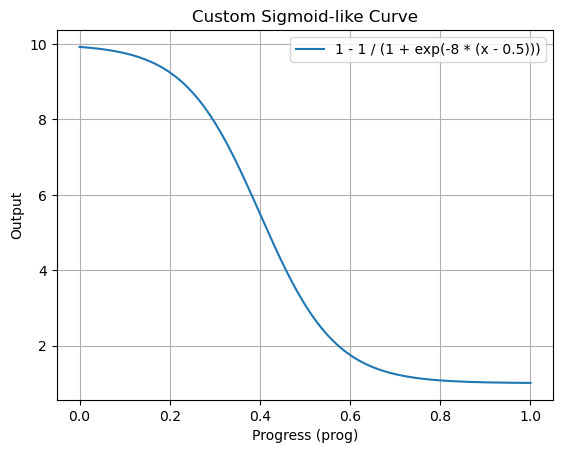

In [61]:
import matplotlib.pyplot as plt

# Define the function
def custom_sigmoid(prog):
    sigmoid = 1.0 / (1.0 + np.exp(-12 * (prog - 0.4)))
    return 10 - (10 - 1) * sigmoid

# Generate x values from 0 to 1
x = np.linspace(0, 1, 500)
y = custom_sigmoid(x)

# Plot
plt.plot(x, y, label='1 - 1 / (1 + exp(-8 * (x - 0.5)))')
plt.title("Custom Sigmoid-like Curve")
plt.xlabel("Progress (prog)")
plt.ylabel("Output")
plt.grid(True)
plt.legend()
plt.show()

In [62]:
[[5,2],[5,3],[],[]]

[[5, 2], [5, 3], [], []]